# Import Iibrary

In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from dataset_generator import DatasetGenerator
from MICE import FillNaN
from apply_PCA import MakePCA


# Load Data

In [2]:
data_path = '../../data'
dataset_gen = DatasetGenerator(data_path)

df = dataset_gen.generate_dataset()

df, category_cols, conti_cols = dataset_gen.feature_engineering(df)


100%|██████████| 107/107 [00:07<00:00, 15.21it/s]


In [3]:
# 파생 변수 생성에만 필요했던 변수들
drop_cols1 = ['long_liquidations_bybit', 'short_liquidations_bybit', 'long_liquidations_bitfinex', 'short_liquidations_bitfinex', 'long_liquidations_binance', 'short_liquidations_binance',
             'buy_volume_deribit', 'sell_volume_deribit','buy_volume_bybit', 'sell_volume_bybit','buy_volume_okx', 'sell_volume_okx']

# corr 0.9 이상
drop_cols2 = [
    'coinbase_premium_gap', 'long_liquidations_usd', 'short_liquidations_usd', 'buy_sell_ratio', 'sell_ratio', 'sell_volume','block_mean', 'block_mean_usd', 'blockreward',
    'fees_total', 'fees_transaction_mean', 'fees_transaction_median', 'supply_total', 'utxo_count', 'supply_new', 'velocity_supply_total', 'fees_reward_percent', 'hashrate', 'sender_count' ]


# 파생 변수 중에 corr 0.9 이상
drop_cols3 = ['long_liquidation_interest_ratio', 'short_liquidation_interest_ratio', 'volume_interest_ratio', 'buy_sell_volume_ratio', 'volume_index']

drop_cols = drop_cols1 + drop_cols2 + drop_cols3

df_select = df.drop(columns = drop_cols)


In [4]:
df_select.head(2)


,ID,target,_type,coinbase_premium_index,funding_rates,funding_rates_bitmex,long_liquidations,short_liquidations,open_interest,buy_ratio,...,fees_activity_ratio,tokens_fee_ratio,block_interval_difficulty_reward_ratio,taker_interest_ratio,premium_liquidation_ratio,velocity_supply_ratio,funding_taker_ratio,M,Is_Afternoon_Evening,Is_Weekend
0,2023-01-01 00:00:00,2.0,train,-0.059650,0.005049,0.0014,0.012,0.000,6.271344e+09,0.475003,...,7.202686e-10,58919.999796,8.421701e+14,0.015604,1.904329e-22,3.590163e-09,179.185118,1,0,1
1,2023-01-01 01:00:00,1.0,train,-0.053047,0.005049,0.0014,0.000,0.712,6.288683e+09,0.623454,...,1.436218e-09,50472.421939,1.125007e+14,0.010140,8.697117e-23,2.350919e-09,327.913566,1,0,1


# Fill Na

In [5]:
fill_nan = FillNaN(df)
filled_df = fill_nan.MICE()


# Log transform

In [6]:
columns_to_log_transform = [
    'funding_rates_bitmex', 'long_liquidations', 'short_liquidations',
    'buy_volume', 'buy_sell_ratio_huobi', 'fees_total_usd',
    'fees_transaction_mean_usd', 'fees_transaction_median_usd', 'blockreward_usd',
    'block_interval', 'tokens_transferred_total', 'tokens_transferred_mean',
    'block_bytes', 'network_active', 'profitability', 'leverage', 'market_health', 
    'tokens_fee_ratio'
]

# 로그 변환: log1p를 사용하여 (log(1 + x)) 적용
df_select[columns_to_log_transform] = df_select[columns_to_log_transform].apply(np.log1p)

# MinMax Scaling

In [7]:
train_df = df_select[df_select._type == 'train'].drop(columns=['_type', 'target', 'ID','M'])
test_df = df_select[df_select._type == 'test'].drop(columns=['_type', 'target', 'ID','M'])

numeric_cols_train = train_df.select_dtypes(include=['float64', 'int64']).columns

scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_df[numeric_cols_train])
train_df[numeric_cols_train] = train_scaled

test_scaled = scaler.transform(test_df[numeric_cols_train])
test_df[numeric_cols_train] = test_scaled

minmaxdf = pd.concat([df_select[['_type', 'target', 'ID','M']], pd.concat([train_df, test_df], axis=0)], axis=1)
minmaxdf.head(2)


,_type,target,ID,M,coinbase_premium_index,funding_rates,funding_rates_bitmex,long_liquidations,short_liquidations,open_interest,...,hashrate_difficulty_reward_ratio,fees_activity_ratio,tokens_fee_ratio,block_interval_difficulty_reward_ratio,taker_interest_ratio,premium_liquidation_ratio,velocity_supply_ratio,funding_taker_ratio,Is_Afternoon_Evening,Is_Weekend
0,train,2.0,2023-01-01 00:00:00,1,0.492212,0.623464,0.702435,0.001562,0.000000,0.385656,...,0.270434,0.001113,0.821765,0.125697,0.009775,1.822592e-22,0.196608,0.770048,0.0,1.0
1,train,1.0,2023-01-01 01:00:00,1,0.494355,0.623463,0.702435,0.000000,0.065954,0.387585,...,0.065730,0.002449,0.803145,0.016748,0.005718,7.879755e-23,0.125858,0.770186,0.0,1.0


# DF1

In [10]:
intervals=[6,12,24,48,72]
ma_col_lst = set(conti_cols)-set(drop_cols)
df_select_ma = dataset_gen.moving_average(minmaxdf, ma_col_lst, intervals)

In [12]:
# ccf 에서 상관성이 높았던 변수들 (EDA 참고)
shift_col_lst = ['funding_rates',  'funding_rates_bitmex', 'open_interest', 'transactions_count_total', 'transactions_count_mean', 'block_mean', 'block_mean_usd',
           'fees_total', 'fees_total_usd', 'fees_reward_percent', 'difficulty', 'utxo_count', 'supply_total', 'hashrate', 'fees_transaction_mean',
           'fees_transaction_mean_usd', 'fees_transaction_median', 'fees_transaction_median_usd', 'blockreward_usd', 'tokens_transferred_mean',
           'tokens_transferred_median', 'velocity_supply_total', 'address_diff', 'profitability', 'fee_index'
]

# shift 변수 추가
shift_col_lst = set(shift_col_lst) - set(drop_cols)
df_select_ma_shift = dataset_gen.shift_feature(df_select_ma, shift_col_lst, intervals=[_ for _ in range(1, 24)])

In [13]:
df_select_ma_shift.head(3)

,_type,target,ID,M,coinbase_premium_index,funding_rates,funding_rates_bitmex,long_liquidations,short_liquidations,open_interest,...,tokens_transferred_mean_14,tokens_transferred_mean_15,tokens_transferred_mean_16,tokens_transferred_mean_17,tokens_transferred_mean_18,tokens_transferred_mean_19,tokens_transferred_mean_20,tokens_transferred_mean_21,tokens_transferred_mean_22,tokens_transferred_mean_23
0,train,2.0,2023-01-01 00:00:00,1,0.492212,0.623464,0.702435,0.001562,0.000000,0.385656,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,train,1.0,2023-01-01 01:00:00,1,0.494355,0.623463,0.702435,0.000000,0.065954,0.387585,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,train,1.0,2023-01-01 02:00:00,1,0.492763,0.623459,0.702435,0.000000,0.000000,0.387375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
_target = df["target"]
final_df = df_select_ma_shift.ffill().fillna(-999).assign(target = _target)

train_df = final_df[final_df._type == 'train'].drop(columns = '_type')
test_df = final_df[final_df._type == 'test'].drop(columns = '_type')

In [15]:
# train_test_split 으로 valid set, train set 분리
x_train_random, x_valid_random, y_train_random, y_valid_random = train_test_split(
    train_df.drop(columns = ['ID', 'target']), 
    train_df["target"].astype(int), 
    test_size=0.2,
    random_state=42,
    stratify=train_df["target"].astype(int) 
)

In [16]:
# time series valid, train set 분리
x_train_ts = train_df[train_df.ID < '2023-11-01'].drop(["target", "ID"], axis = 1)
y_train_ts = train_df[train_df.ID < '2023-11-01']["target"].astype(int)

x_valid_ts = train_df[train_df.ID >= '2023-11-01'].drop(["target", "ID"], axis = 1)
y_valid_ts = train_df[train_df.ID >= '2023-11-01']["target"].astype(int)

In [17]:
x_train_random.replace([np.inf, -np.inf], np.nan, inplace=True)
x_valid_random.replace([np.inf, -np.inf], np.nan, inplace=True)

x_train_ts.replace([np.inf, -np.inf], np.nan, inplace=True)
x_valid_ts.replace([np.inf, -np.inf], np.nan, inplace=True)

In [18]:
# 모델 불러와서 예측하고 변수 중요도 추출
df1_list = []

In [19]:
df1 = minmaxdf[df1_list]
df1.head()

""
0
1
2
3
4


# DF2 - PCA 활용

In [20]:
pca = MakePCA(df_select)

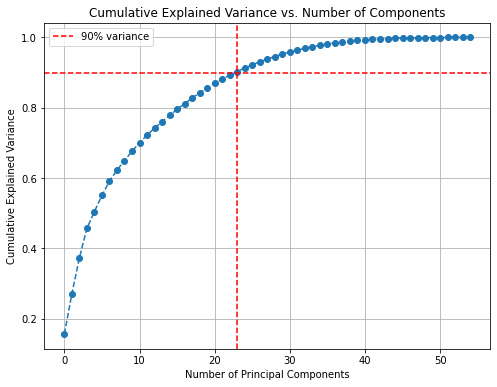

24


In [21]:
num = pca.Find_PCA_n(visualize=True)
print(num)

In [22]:
pca_df = pca.ApplyPCA(num)
pca_df.head(2)

,ID,_type,target,PC1,PC2,PC3,PC4,PC5,PC6,PC7,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
0,2023-01-01 00:00:00,train,2.0,-7.616700,3.902004,-0.372305,-1.408289,0.170445,-1.217880,5.171932,...,-0.305315,-2.395149,-0.537599,1.436379,0.154574,0.207808,0.864349,-0.192667,-0.576136,0.719176
1,2023-01-01 01:00:00,train,1.0,-5.108229,-1.748376,2.212699,-3.108076,-0.160802,-0.919286,1.340964,...,-0.838288,-1.818784,-1.682709,2.565083,-0.108025,-0.273851,0.249715,-0.238398,-0.079584,-0.269397


In [24]:
intervals = [6,12,24,48,72]

# ccf 에서 상관성이 높았던 변수들 
col_lst = [f'PC{i+1}' for i in [1,3,5,11,12,13,18]]

df_select_ma = dataset_gen.moving_average(pca_df, col_lst, intervals)


In [25]:
shift_intervals = [_ for _ in range(1, 24)]

df_shifted = dataset_gen.shift_feature(df_select_ma, col_lst, shift_intervals)


In [26]:
df_shifted.head(2)

,ID,_type,target,PC1,PC2,PC3,PC4,PC5,PC6,PC7,...,PC19_14,PC19_15,PC19_16,PC19_17,PC19_18,PC19_19,PC19_20,PC19_21,PC19_22,PC19_23
0,2023-01-01 00:00:00,train,2.0,-7.616700,3.902004,-0.372305,-1.408289,0.170445,-1.217880,5.171932,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-01 01:00:00,train,1.0,-5.108229,-1.748376,2.212699,-3.108076,-0.160802,-0.919286,1.340964,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# 모델링

In [28]:
# 변수 중요도 뽑아서

In [29]:
df2_list = []
df2 = df_shifted[df2_list]

df2.head()


""
0
1
2
3
4


# DF3 - 상승 하락 확률

In [30]:
up_down_df = df_select_ma_shift.copy()

In [31]:
# 타겟 변수 생성 (예: 4개 클래스로 분류)
up_down_df['target_direction'] = np.where(up_down_df['target'] >= 2, 1, 0)

In [32]:
train_df = up_down_df[up_down_df._type == 'train'].drop(columns = '_type')
test_df = up_down_df[up_down_df._type == 'test'].drop(columns = '_type')

In [33]:
# train_test_split 으로 valid set, train set 분리
x_train_random, x_valid_random, y_train_dir_random, y_valid_dir_random = train_test_split(
    train_df.drop(columns = ['target_direction', 'ID',  'target']), 
    train_df["target_direction"].astype(int), 
    test_size=0.2,
    random_state=42,
    stratify = train_df['target']
)

In [34]:
# time series valid, train set 분리
x_train_ts = train_df[train_df.ID < '2023-11-01'].drop(columns=['target_direction', 'ID', 'target'])
y_train_dir_ts = train_df[train_df.ID < '2023-11-01']["target_direction"]

x_valid_ts = train_df[train_df.ID >= '2023-11-01'].drop(columns=['target_direction', 'ID', 'target'])
y_valid_dir_ts = train_df[train_df.ID >= '2023-11-01']["target_direction"]

In [35]:
# catboost 모델 돌리기

In [ ]:
# # ts split 버전
# dir_prob_train = catboost_ts.predict_proba(x_train_ts)[:,1]
# dir_prob_valid = catboost_ts.predict_proba(x_valid_ts)[:,1]
# dir_prob_ts = np.concatenate((dir_prob_train,dir_prob_valid))

In [ ]:
# # random split 버전 
# dir_prob_train = catboost_random.predict_proba(x_train_random)[:,1]
# dir_prob_valid = catboost_random.predict_proba(x_valid_random)[:,1]
# dir_prob_random = np.concatenate((dir_prob_train,dir_prob_valid))

In [ ]:
# # 테스트셋용 
# x_test_full = test_df.drop(columns = ['ID', 'target', 'target_direction'])
# dir_prob_random_test = catboost_random.predict_proba(x_test_full)[:,1] # random 용
# dir_prob_ts_test = catboost_ts.predict_proba(x_test_full)[:,1] # ts 용

In [ ]:
# df3_1 = pd.DataFrame()
# df3_1['dir_prob_ts'] = dir_prob_ts
# df3_1['dir_prob_random'] = dir_prob_random

# df3_2 = pd.DataFrame()
# df3_2['dir_prob_ts'] = dir_prob_ts_test
# df3_2['dir_prob_random'] = dir_prob_random_test

# df3 = pd.concat([df3_1,df3_2],axis=0)
# df3 = df3.reset_index(drop=True)
# df3


# Concat DF

In [ ]:
# df4 = pd.concat([df[['ID','_type','target']],df1, df2, df3],axis=1)
# df4